In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [10]:
# if you don't have dowhy installed, uncomment the following line
!pip install dowhy

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/989.5 kB ? eta -:--:--
   ---------------------------------------- 989.5/989.5 kB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/742.5 kB ? eta -:--:--
   ---------------------------------------- 742.5/742.5 kB 5.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   ------------------------------- -------- 5.8/7.4 MB 25.1 MB/s eta 0:00:01
   ---------------------------------------  7.3/7.4 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------- 7.4/7.4 MB 12.8 MB/s eta 0:00:00


### Creating a psudo relational graph on fast food and weight gain

In [28]:
import networkx as nx

causal_graph = nx.DiGraph([('Education', 'Income'),
                           ('Income', 'Fast_Food'),
                           ('Fast_Food', 'Weight_Gain'),
                           ('Fast_Food', 'Health'),
                           ('Exercise', 'Health'),
                           ('Stress', 'Fast_Food'),
                           ('Stress', 'Health'),
                           ('Stress', 'Weight_Gain'),
                           ('Weight_Gain', 'Exercise'),
                           ('Education', 'Stress')
                           ])

#### Let's visiualize the graph 

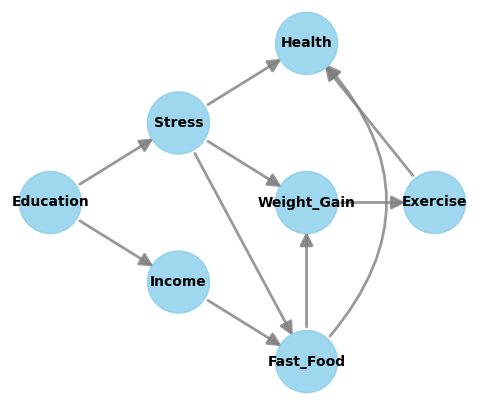

In [29]:
from dowhy.utils import plot

plot(causal_graph)

#### We are generating a data set and would test the relationship as well.

In [15]:
# Step 1: Generate a synthetic dataset with a causal structure
np.random.seed(42)

# Define the number of samples
n = 500  

# Simulated causal relationships
education = np.random.randint(10, 20, n)  # Years of education
income = education * 2000 + np.random.normal(0, 5000, n)  # Higher education → higher income
exercise = np.random.randint(0, 10, n)  # Hours of exercise per week
health = income * 0.0005 + exercise * 1.5 + np.random.normal(0, 5, n)  # Income & exercise → health
stress = 50 - 0.01 * income + np.random.normal(0, 3, n)  # Higher income → lower stress
fast_food = np.random.randint(1, 5, n) + stress * 0.2 + np.random.normal(0, 1, n)  # Stress increases fast food consumption
weight_gain = fast_food * 3 - exercise * 1.2 + np.random.normal(0, 2, n)  # Fast food ↑, exercise ↓ affects weight gain

# Create a DataFrame
data = pd.DataFrame({
    'Education': education,
    'Income': income,
    'Exercise': exercise,
    'Health': health,
    'Stress': stress,
    'Fast_Food': fast_food,
    'Weight_Gain': weight_gain
})


In [16]:
data.head()

,Education,Income,Exercise,Health,Stress,Fast_Food,Weight_Gain
0,16,38527.394036,8,34.353841,-329.788160,-63.537087,-201.597229
1,13,26105.019208,1,15.257693,-204.993294,-40.301614,-120.503347
2,17,37409.764856,0,21.234582,-324.903053,-63.400557,-187.725196
3,14,26448.666217,9,31.676100,-216.577481,-39.304420,-130.467245
4,16,33620.831762,1,9.055714,-288.492704,-57.187691,-176.467727


In [30]:
from dowhy import gcm
gcm.util.general.set_random_seed(0)

# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(scm, data)

In [31]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [32]:
gcm.fit(scm, data)

Fitting causal mechanism of node Stress: 100%|██████████| 7/7 [00:00<00:00, 330.27it/s]


In [33]:
print(gcm.evaluate_causal_model(scm, data, compare_mechanism_baselines=True, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

Evaluating causal mechanisms...: 100%|██████████| 7/7 [00:00<00:00, 3443.60it/s]


Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked Probability Score (CRPS):

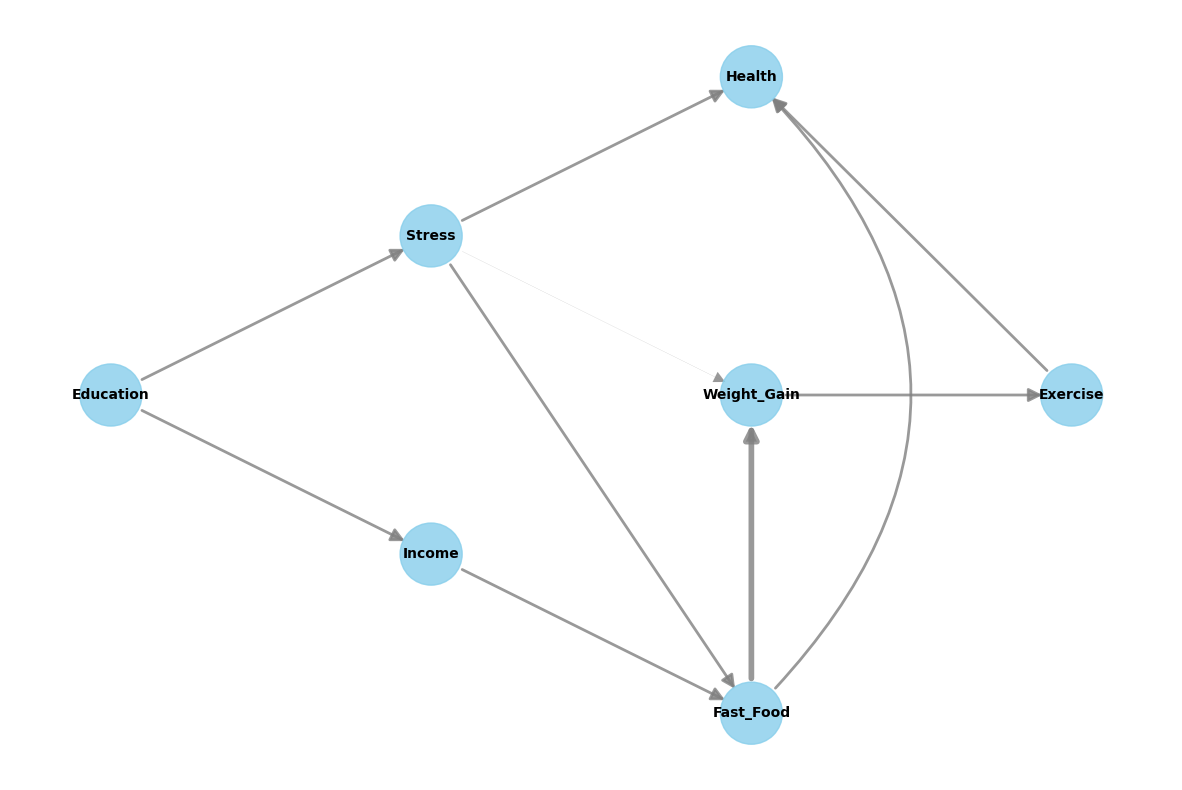

In [34]:
import numpy as np

# Note: The percentage conversion only makes sense for purely positive attributions.
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='Weight_Gain')

plot(causal_graph,
     causal_strengths=convert_to_percentage(arrow_strengths),
     figure_size=[15, 10])

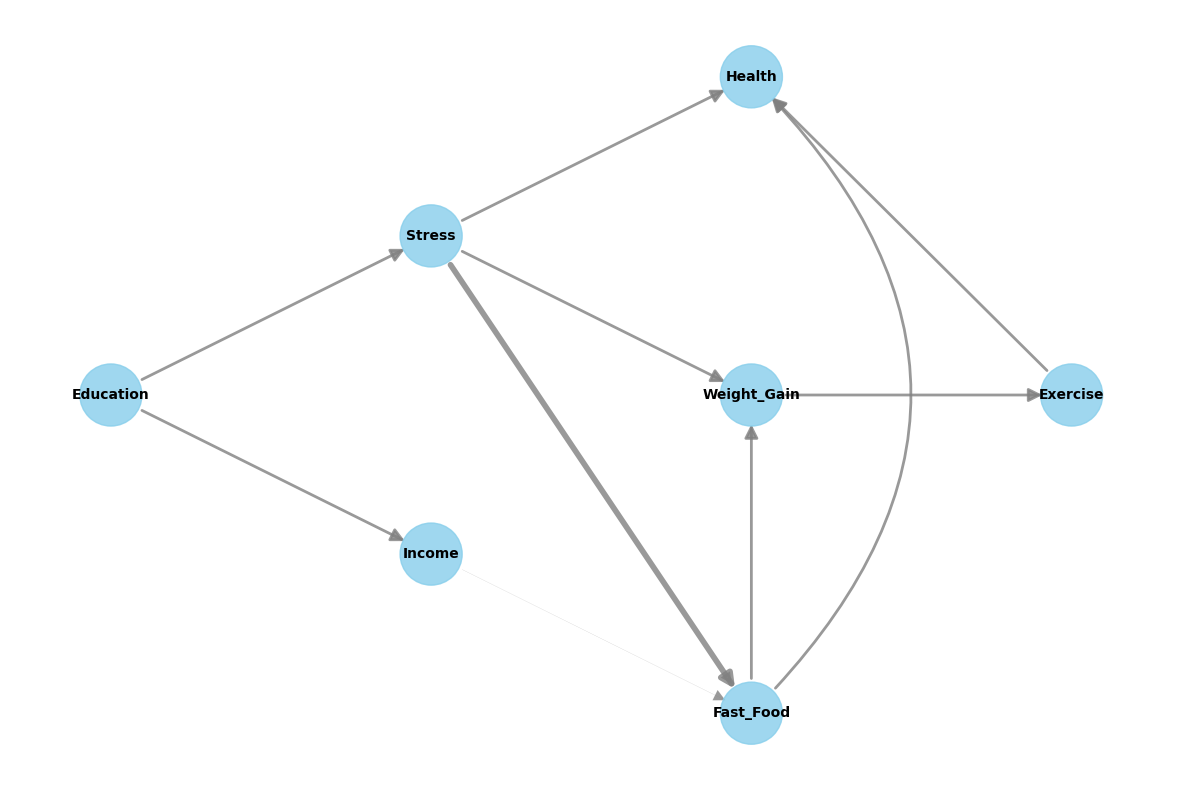

In [36]:
import numpy as np

# Note: The percentage conversion only makes sense for purely positive attributions.
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='Fast_Food')

plot(causal_graph,
     causal_strengths=convert_to_percentage(arrow_strengths),
     figure_size=[15, 10])

In [35]:
arrow_strengths

{('Fast_Food', 'Weight_Gain'): 2220.810891849939,
 ('Stress', 'Weight_Gain'): 1.3638185189061367}

#### Now , I hope you have a pretty good idea on how to generate a causal graph based on any data

Reference: https://www.pywhy.org/dowhy/v0.8/getting_started/intro.html